# Create a logistic regression model to predict TP53 mutation from gene expression data in TCGA

In [1]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, grid_search
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from statsmodels.robust.scale import mad
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import FactorAnalysis
from sklearn.externals import joblib
from sklearn.svm import SVC

/Users/sharimoskow1/anaconda/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/sharimoskow1/anaconda/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Specify model configuration

In [3]:
# We're going to be building a 'TP53' classifier 
GENE = '7157' # TP53

In [4]:
# SGDClassifier Parameter Sweep
sgd_n_feature_kept = 500
sgd_param_fixed = {
    'loss': 'log',
    'penalty': 'elasticnet',
}
sgd_param_grid = {
    'alpha': [0.1],
    'l1_ratio': [0.0],
}

In [5]:
# AdaBoost Parameter Sweep
adaboost_n_feature_kept = 5000
adaboost_param_fixed = {
    'algorithm': 'SAMME.R',
    'base_estimator': DecisionTreeClassifier(max_depth=1)
}
adaboost_param_grid = {
    'learning_rate': [0.5],
    'n_estimators': [50]
}

In [6]:
# Parameter Sweep for Hyperparameters
pca_n_feature_kept = 2000
pca_param_fixed = {
    'loss': 'log',
    'penalty': 'elasticnet',
    'n_components': 500,
}
pca_param_grid = {
    'alpha': [0.1],
    'l1_ratio': [0.0],
}

*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

*Here is some [information](https://ghr.nlm.nih.gov/gene/TP53) about TP53*

## Load Data

In [7]:
%%time
path = os.path.join('..', 'download', 'expression-matrix.tsv.bz2')
X = pd.read_table(path, index_col=0)

CPU times: user 3min 42s, sys: 6.82 s, total: 3min 49s
Wall time: 3min 53s


In [8]:
%%time
path = os.path.join('..', 'download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 2min 33s, sys: 6.57 s, total: 2min 40s
Wall time: 2min 42s


In [9]:
y = Y[GENE]

In [10]:
# The Series now holds TP53 Mutation Status for each Sample
y.head(6)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    1
TCGA-02-2483-01    1
TCGA-02-2485-01    1
TCGA-02-2486-01    0
TCGA-04-1348-01    1
Name: 7157, dtype: int64

In [11]:
# Here are the percentage of tumors with NF1
y.value_counts(True)

0    0.645907
1    0.354093
Name: 7157, dtype: float64

## Set aside 10% of the data for testing

In [12]:
# Typically, this can only be done where the number of mutations is large enough
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(len(X.columns), len(X_train), len(X_test))

'Size: 20,468 features, 6,575 training samples, 731 testing samples'

## Median absolute deviation feature selection

In [13]:
def fs_mad(x, y):
    """    
    Get the median absolute deviation (MAD) for each column of x
    """
    scores = mad(x) 
    return scores, np.array([np.NaN]*len(scores))

## SGD Calssifier¶

In [14]:
# joblib is used to cross-validate in parallel by setting `n_jobs=-1` in GridSearchCV
# Supress joblib warning. See https://github.com/scikit-learn/scikit-learn/issues/6370
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')

sgd_clf = SGDClassifier(random_state=0, class_weight='balanced',
                        loss=sgd_param_fixed['loss'], penalty=sgd_param_fixed['penalty'])

sgd_pipeline = make_pipeline(
    SelectKBest(fs_mad, k=sgd_n_feature_kept),  # Feature selection
    StandardScaler(),  # Feature scaling
    sgd_clf)

## AdaBoost Classifier

In [15]:
# Include loss='log' in param_grid doesn't work with pipeline somehow
adaboost_clf = AdaBoostClassifier(random_state=0,
                                  base_estimator=adaboost_param_fixed['base_estimator'],
                                  algorithm=adaboost_param_fixed['algorithm'])

adaboost_pipeline = make_pipeline(
    SelectKBest(fs_mad, k=adaboost_n_feature_kept),  # Feature selection
    StandardScaler(),  # Feature scaling
    adaboost_clf)

## PCA Classifier

In [16]:
# Include loss='log' in param_grid doesn't work with pipeline somehow
pca_pipeline = make_pipeline(
    SelectKBest(fs_mad, k=pca_n_feature_kept),
    FactorAnalysis(n_components=pca_param_fixed['n_components']),  # Feature selection
    StandardScaler(),  # Feature scaling
    sgd_clf)

## Voting Classifier

In [17]:
prefixes = ["sgd__sgdclassifier", "adaboost__adaboostclassifier", "pca__sgdclassifier"]
param_grids = [sgd_param_grid, adaboost_param_grid, pca_param_grid]
weights = [(1.0, 0.0, 0.0), (0.0, 1.0, 0.0), (0.0, 0.0, 1.0),
           (0.0, 0.5, 0.5), (0.5, 0.0, 0.5), (0.5, 0.5, 0.0),
           (1.0/3, 1.0/3, 1.0/3)]

param_grid = {}
for prefix, orig_param_grid in zip(prefixes, param_grids):
    param_grid.update(dict(zip(["%s__%s" % (prefix, p) for p in orig_param_grid.keys()],
                                orig_param_grid.values())))

for weight in weights:
    
    param_grid.update(dict(weights=[weight]))
    
    estimators = [('sgd', sgd_pipeline), ('adaboost', adaboost_pipeline), ('pca', pca_pipeline)]
    voting_clf = VotingClassifier(estimators=estimators, voting='soft') 
    assert np.all([p in voting_clf.get_params().keys() for p in param_grid.keys()])

    voting_grid = grid_search.GridSearchCV(estimator=voting_clf, param_grid=param_grid,
                                           n_jobs=-1, scoring='roc_auc')
    %time voting_grid.fit(X=X_train, y=y_train)

    weight_name = "_".join(["%i" % (100 * w) for w in weight])
    print ("... done %s ..." % weight_name)
    joblib.dump(voting_grid, "../results/voting_clf_%s.pkl" % weight_name)

/Users/sharimoskow1/anaconda/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/sharimoskow1/anaconda/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/sharimoskow1/anaconda/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


CPU times: user 4min 51s, sys: 24.7 s, total: 5min 16s
Wall time: 23h 39min 26s
... done 100_0_0 ...


/Users/sharimoskow1/anaconda/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/sharimoskow1/anaconda/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/sharimoskow1/anaconda/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


CPU times: user 6min 6s, sys: 28.6 s, total: 6min 34s
Wall time: 9h 33min 11s
... done 0_100_0 ...


/Users/sharimoskow1/anaconda/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/sharimoskow1/anaconda/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/sharimoskow1/anaconda/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


CPU times: user 6min 1s, sys: 27.7 s, total: 6min 28s
Wall time: 3h 57min 13s
... done 0_0_100 ...


/Users/sharimoskow1/anaconda/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/sharimoskow1/anaconda/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/sharimoskow1/anaconda/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


CPU times: user 6min 13s, sys: 25.7 s, total: 6min 38s
Wall time: 20h 34s
... done 0_50_50 ...


/Users/sharimoskow1/anaconda/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/sharimoskow1/anaconda/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/sharimoskow1/anaconda/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


CPU times: user 6min 24s, sys: 28.7 s, total: 6min 52s
Wall time: 5h 47min 47s
... done 50_0_50 ...


/Users/sharimoskow1/anaconda/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/sharimoskow1/anaconda/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/sharimoskow1/anaconda/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


CPU times: user 5min 44s, sys: 25 s, total: 6min 9s
Wall time: 20h 52min 35s
... done 50_50_0 ...


/Users/sharimoskow1/anaconda/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/sharimoskow1/anaconda/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/sharimoskow1/anaconda/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


CPU times: user 4min 51s, sys: 24.7 s, total: 5min 16s
Wall time: 21h 52min 1s
... done 33_33_33 ...


## Reload Estimators

In [18]:
weights = [(1.0, 0.0, 0.0), (0.0, 1.0, 0.0), (0.0, 0.0, 1.0),
           (0.0, 0.5, 0.5), (0.5, 0.0, 0.5), (0.5, 0.5, 0.0),
           (1.0/3, 1.0/3, 1.0/3)]

In [19]:
sgd_weights = []
adaboost_weights = []
pca_weights = []
mean_scores = []

for weight in weights:
    weight_name = "_".join(["%i" % (100 * w) for w in weight])
    sgd_weights.append(weight[0])
    adaboost_weights.append(weight[1])
    pca_weights.append(weight[2])
    mean_scores.append(joblib.load("../results/voting_clf_%s.pkl" % weight_name).grid_scores_[0].mean_validation_score)

result_dat = pd.DataFrame(dict(sgd_weight=sgd_weights, adaboost_weight=adaboost_weights,
                               pca_weight=pca_weights, score=mean_scores))
result_dat = result_dat[['sgd_weight', 'adaboost_weight', 'pca_weight', 'score']]
print (result_dat)

   sgd_weight  adaboost_weight  pca_weight     score
0    1.000000         0.000000    0.000000  0.885522
1    0.000000         1.000000    0.000000  0.909627
2    0.000000         0.000000    1.000000  0.921895
3    0.000000         0.500000    0.500000  0.924802
4    0.500000         0.000000    0.500000  0.915533
5    0.500000         0.500000    0.000000  0.891402
6    0.333333         0.333333    0.333333  0.917108


## Use Optimal Hyperparameters to Output ROC Curve

In [20]:
optimal_weight = (0.0, 0.5, 0.5)
weight_name = "_".join(["%i" % (100 * w) for w in optimal_weight])
best_clf = joblib.load("../results/voting_clf_%s.pkl" % weight_name)

In [21]:
y_pred_train = best_clf.best_estimator_.predict_proba(X_train).T[1]
y_pred_test = best_clf.best_estimator_.predict_proba(X_test).T[1]

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_train = get_threshold_metrics(y_train, y_pred_train)
metrics_test = get_threshold_metrics(y_test, y_pred_test)

In [22]:
%matplotlib inline

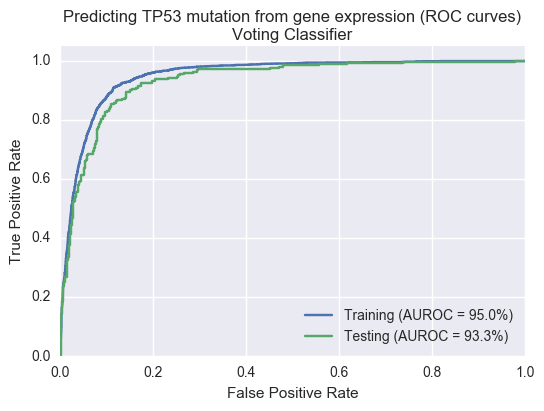

In [23]:
# Plot ROC
plt.figure()
for label, metrics in ('Training', metrics_train), ('Testing', metrics_test):
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting TP53 mutation from gene expression (ROC curves)\nVoting Classifier')
plt.legend(loc='lower right');

## Compare with Simple Classifiers

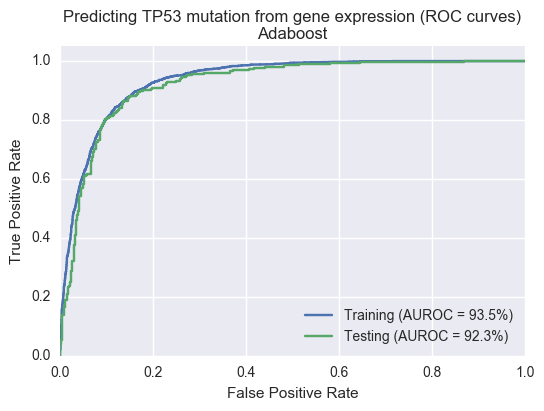

In [24]:
optimal_weight = (0.0, 1.0, 0.0)
weight_name = "_".join(["%i" % (100 * w) for w in optimal_weight])
best_clf = joblib.load("../results/voting_clf_%s.pkl" % weight_name)

adaboost_y_pred_train = best_clf.best_estimator_.predict_proba(X_train).T[1]
adaboost_y_pred_test = best_clf.best_estimator_.predict_proba(X_test).T[1]
adaboost_metrics_train = get_threshold_metrics(y_train, adaboost_y_pred_train)
adaboost_metrics_test = get_threshold_metrics(y_test, adaboost_y_pred_test)

# Plot ROC
plt.figure()
for label, metrics in ('Training', adaboost_metrics_train), ('Testing', adaboost_metrics_test):
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting TP53 mutation from gene expression (ROC curves)\nAdaboost')
plt.legend(loc='lower right');

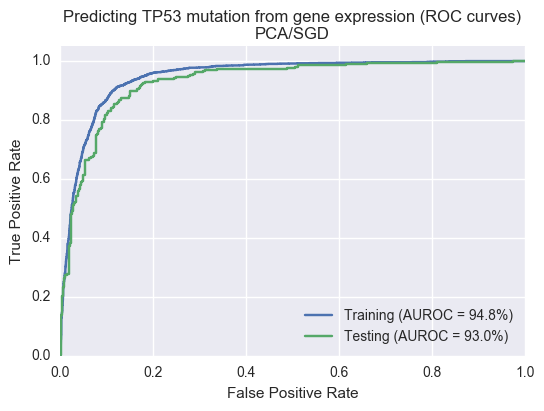

In [25]:
optimal_weight = (0.0, 0.0, 1.0)
weight_name = "_".join(["%i" % (100 * w) for w in optimal_weight])
best_clf = joblib.load("../results/voting_clf_%s.pkl" % weight_name)

adaboost_y_pred_train = best_clf.best_estimator_.predict_proba(X_train).T[1]
adaboost_y_pred_test = best_clf.best_estimator_.predict_proba(X_test).T[1]
adaboost_metrics_train = get_threshold_metrics(y_train, adaboost_y_pred_train)
adaboost_metrics_test = get_threshold_metrics(y_test, adaboost_y_pred_test)

# Plot ROC
plt.figure()
for label, metrics in ('Training', adaboost_metrics_train), ('Testing', adaboost_metrics_test):
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting TP53 mutation from gene expression (ROC curves)\nPCA/SGD')
plt.legend(loc='lower right');